In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from scipy.stats import fisher_exact

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
flierprops = dict(markerfacecolor='lightgrey',markeredgecolor='lightgrey')
from statannot import add_stat_annotation

import sys
sys.path.append('../utils')
from stat_annot_utils import create_pairs, create_hue_pairs, parse_results_from_statannot
from plot_medians_in_boxplot import plot_medians_in_boxplot
from cliffs_d import calc_boxplot_effect_size

### Load data

In [3]:
clinical = pd.read_csv('../data/liu_ICB_NatMed2019/data_summary.cleaned.tsv', sep='\t')

print(clinical.shape)
clinical.head(2)

(122, 14)


,No.,Run,Patient,Unnamed: 3,biopsy site,MPS,days Biopsy To PD1,days Biopsy After Ipi Start,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),Unnamed: 9,BR,PFS,OS,biopsyContext
0,56,SRR10900001,Patient1,T_M,skin,-393.07,-84,NaN,3seq,③,PD,93,283,pre-PD1
1,6,SRR10842352,Patient10,T_M,skin,-169.61,-12,107.0,3seq,③,PR,169,1139,pre-PD1


In [5]:
maf = pd.read_csv('../data/liu_ICB_NatMed2019/muts.with_location.tsv', sep='\t')
print(maf.shape)
maf.head(2)

(122262, 34)


,Hugo_Symbol,Chromosome,Variant_Classification,Variant_Type,cDNA_Change,Protein_Change,Start_position,End_position,Reference_Allele,Tumor_Seq_Allele1,...,Protein names,Gene names,Organism,Length,Gene ontology (cellular component),Gene ontology IDs,cc_ids,UMAP1,UMAP2,gene
0,LRP1B,2,Missense_Mutation,SNP,c.2482G>A,p.E828K,141762925,141762925,C,C,...,Low-density lipoprotein receptor-related prote...,LRP1B LRPDIT,Homo sapiens (Human),4599,integral component of membrane [GO:0016021]; r...,GO:0005509; GO:0006898; GO:0015031; GO:0016021...,"['GO:0016021', 'GO:0043235']",0.648405,-0.69124,LRP1B
1,LRP1B,2,Silent,SNP,c.12963G>A,p.Q4321Q,141055381,141055381,C,C,...,Low-density lipoprotein receptor-related prote...,LRP1B LRPDIT,Homo sapiens (Human),4599,integral component of membrane [GO:0016021]; r...,GO:0005509; GO:0006898; GO:0015031; GO:0016021...,"['GO:0016021', 'GO:0043235']",0.648405,-0.69124,LRP1B


In [6]:
# merge clinical and mutations
df = pd.merge(maf, clinical, on=['Patient'], how='left')
print(df.shape)
df = df.dropna(subset=['BR'])
print(df.shape)
df = df.dropna(subset=['cc_ids'])
print(df.shape)

df.head(2)

(122262, 47)
(96477, 47)
(96477, 47)


,Hugo_Symbol,Chromosome,Variant_Classification,Variant_Type,cDNA_Change,Protein_Change,Start_position,End_position,Reference_Allele,Tumor_Seq_Allele1,...,biopsy site,MPS,days Biopsy To PD1,days Biopsy After Ipi Start,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),Unnamed: 9,BR,PFS,OS,biopsyContext
0,LRP1B,2,Missense_Mutation,SNP,c.2482G>A,p.E828K,141762925,141762925,C,C,...,skin,-486.04,-22.0,NaN,3,④,MR,378.0,521.0,on-PD1
1,LRP1B,2,Silent,SNP,c.12963G>A,p.Q4321Q,141055381,141055381,C,C,...,skin,-200.90,-112.0,-13.0,1,①,PD,99.0,626.0,pre-Ipi


##### Preprocess

In [7]:
# Ignore noncoding and silent mutation types for TMB calculation
noncoding_silent_mut_types = ['Silent','RNA','Intron','5\'UTR','3\'UTR','Start_Codon_Del',
                              'Stop_Codon_Ins','Nonsense_Mutation']

df = df[~df['Variant_Classification'].isin(noncoding_silent_mut_types)]
df.shape

(59939, 47)

In [15]:
# load previously observed immunogenic locations
immunogenic_loc = np.load('../data/generated_data/previously_obs_immunogenic_loc.npy', allow_pickle=True)
len(immunogenic_loc)


368

In [16]:
# annotate
df['prev_seen_immuno'] = df['cc_ids'].apply(lambda x: frozenset(literal_eval(x)) in immunogenic_loc)

### Analysis for responders to be enriched for mutations in locations that were previously seen to induce an immunogenic response

In [17]:
df['response_binary'] = df['BR'].map({'CR': 'response', 'PR': 'response', 'PD': 'nonresponse', })

ct = pd.crosstab(df['prev_seen_immuno'], df['response_binary'])
ct = ct[['response','nonresponse']]    
ct = ct.sort_index(ascending=False, axis=0)
print(fisher_exact(ct))
ct

(1.0649724250614045, 0.0014963437963711294)


response_binary,response,nonresponse
prev_seen_immuno,,
True,7493,6237
False,21578,19128


### Plot filtered TMB

Effect size (filtered): response/nonresponse r=0.2258
../data/publication_figures/Fig4.LiuNatMed.tmb_filtered.boxplot.pdf


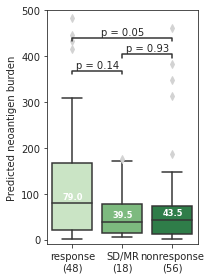

In [20]:
plt.figure(figsize=(3,4))

ylabel_dict = {'filtered': 'Predicted neoantigen burden'}
i=1

for tmb_df, f_status in [(pd.DataFrame(df[df['prev_seen_immuno']==True]['Patient'].value_counts()), 'filtered')]:
    
    # add clinical/response info
    tmb_df = tmb_df.join(clinical.set_index('Patient'))
    tmb_df = tmb_df.rename(columns={'Patient': 'tmb'})
    tmb_df['response_binary'] = tmb_df['BR'].map({'CR': 'response', 'PR': 'response', 
                                                  'PD': 'nonresponse', 'SD':'SD/MR', 'MR': 'SD/MR'})

    x, y = 'response_binary', 'tmb'
    order = ['response','SD/MR','nonresponse']
    ax = sns.boxplot(x=x, y=y, data=tmb_df,order=order, palette='Greens', flierprops=flierprops)
    plt.ylim(-10,350)
    stat_res = add_stat_annotation(ax=ax, x=x, y=y, data=tmb_df, order=order, text_format='simple', verbose=0,
                            comparisons_correction=None,
                            test='Mann-Whitney', loc='outside',
                            box_pairs=create_pairs(order),)
    plt.ylim(-10,500)
    
    # calculate effect size
    stat_res = parse_results_from_statannot(stat_res)
    U = stat_res['nonresponse','response'][0]
    print('Effect size ({}): response/nonresponse r={:.4}'.format(f_status,
                                                                calc_boxplot_effect_size(len(tmb_df[tmb_df[x]=='nonresponse']), 
                                                                                      len(tmb_df[tmb_df[x]=='response']), U)))

    # plot medians and counts
    medians = tmb_df.groupby(x)[y].median()
    plot_medians_in_boxplot(medians, vertical_offset=10, ax=ax, fontcolor='w')

    counts = tmb_df[x].value_counts()
    
    ax.set_xticklabels(['{}\n({})'.format(x.get_text(), counts.loc[x.get_text()]) for x in ax.get_xticklabels()])
    plt.xlabel('')

    if f_status in ylabel_dict:
        plt.ylabel(ylabel_dict[f_status])
    i+=1
    
plt.tight_layout()
savepath = '../data/publication_figures/Fig4.LiuNatMed.tmb_filtered.boxplot.pdf'
print(savepath)
plt.savefig(savepath)
plt.show()

### Create effect size plot for filtered TMB vs unfiltered TMB vs predicted immunogenic neoantigen burden

In [21]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

In [22]:
pep_df = pd.read_csv('../data/liu_ICB_NatMed2019/neopeptides.best_allele_per_mut.merged.tsv', sep='\t')
print(pep_df.shape)
pep_df['nM'] = pep_df['br_nM']
pep_df.head(1)

(36949, 24)


,Mutation_ID,allele,br_nM,br_peptide,patient,nmer,foreignness_score,Peptide,Thalf(h),HLA allele,...,Protein names,Gene names,Organism,Length,Gene ontology (cellular component),Gene ontology IDs,cc_ids,UMAP1,UMAP2,nM
0,M_OR2A12_R121W,HLA-A02:01,1.649,VMMCYDWYV,Patient179,VMMCYDWYV,1.0,VMMCYDWYV,37.4879,HLA-A02:01,...,Olfactory receptor 2A12 (Olfactory receptor OR...,OR2A12 OR2A12P,Homo sapiens (Human),310.0,integral component of membrane [GO:0016021]; p...,GO:0004930; GO:0004984; GO:0005886; GO:0016021,"['GO:0016021', 'GO:0005886']",0.792989,-0.531198,1.649


#### Predict immunogenic peptides using RF model trained on IEDB+Wells+Liu (OV)

In [24]:
# location model
rf = joblib.load('../data/generated_data/Wells_and_IEDB_and_Liu.RF.train_all.aff_stab_foreign_loc.hyperboloid_disk.joblib')
xcols = ['nM','Thalf(h)','foreignness_score', 'UMAP1', 'UMAP2'] 

model_loc_df = pep_df.dropna(subset=xcols)
model_loc_df['preds'] = rf.predict_proba(model_loc_df[xcols])[:,1]

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# no location model
rf = joblib.load('../data/generated_data/Wells_and_IEDB_and_Liu.RF.train_all.aff_stab_foreign.hyperboloid_disk.joblib')
xcols = ['nM','Thalf(h)','foreignness_score', ] 

model_noloc_df = pep_df.dropna(subset=xcols)
model_noloc_df['preds'] = rf.predict_proba(model_noloc_df[xcols])[:,1]

In [26]:
# use optimal thresholds to binarize
model_loc = model_loc_df[model_loc_df['preds']>0.35].pivot_table(index='patient', values='br_peptide', aggfunc='count')
model_noloc = model_noloc_df[model_noloc_df['preds']>0.375].pivot_table(index='patient', values='br_peptide', aggfunc='count')
model_tmb_only_df = pep_df.dropna(subset=xcols)[pep_df.dropna(subset=xcols)['nM']<500].pivot_table(index='patient', values='br_peptide', aggfunc='count')

#### Plot burden and calculate effect sizes

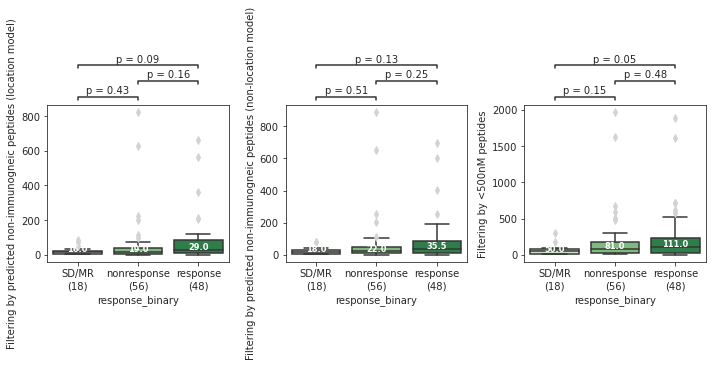

In [27]:
e_list, label_list = [],[]

plt.figure(figsize=(10,4))
ylabel_dict = {'model_loc': 'Filtering by predicted non-immunogneic peptides (location model)',
               'model_noloc': 'Filtering by predicted non-immunogneic peptides (non-location model)',
               'tmb_500nM': 'Filtering by <500nM peptides'}                     
i=0

for l, df in [('model_loc', model_loc),
              ('model_noloc', model_noloc),
              ('tmb_500nM', model_tmb_only_df)]:
    plt.subplot(1,3,i+1)
    
    # add clinical/response
    df = clinical.set_index('Patient').join(df, how='left')
    df['response_binary'] = df['BR'].map({'CR': 'response', 'PR': 'response', 
                                                  'PD': 'nonresponse', 'SD':'SD/MR', 'MR': 'SD/MR'})

    # plot
    x, y = 'response_binary','br_peptide'
    order = sorted(df[x].unique())

    bp = sns.boxplot(x=x, y=y, data=df, palette='Greens',order=order,flierprops=flierprops,)

    # calculate effect size
    stat_res= add_stat_annotation(ax=bp, x=x, y=y, box_pairs=create_pairs(order), order=order, 
                        test='Mann-Whitney',comparisons_correction=None, text_format='simple',
                        data=df, loc='outside', verbose=False)
    stat_res = parse_results_from_statannot(stat_res)
    
    for pair in create_pairs(order):
        pair = sorted(pair)
        U = stat_res[tuple(pair)][0]
        e = calc_boxplot_effect_size(len(df[df[x]==pair[0]]), len(df[df[x]==pair[1]]), U)
    
#         print(l, 'Effect size ({}): {} r={:.3}'.format('with location' if i%2==0 else 'without location',
#             '/'.join(pair), e))
        if pair == ['nonresponse','response']:
            e_list.append(e)
            label_list.append(ylabel_dict[l])
    
    # plot medians and counts
    medians = df.groupby([x])[y].median()
    plot_medians_in_boxplot(medians, vertical_offset=2, ax=bp)
    
    counts = df[x].value_counts()
    
    if l in ylabel_dict: plt.ylabel(ylabel_dict[l])
    bp.set_xticklabels(['{}\n({})'.format(x.get_text(), counts.loc[x.get_text()]) 
                        for x in bp.get_xticklabels()])

    i+=1


plt.tight_layout()
plt.show()

#### Compare effect sizes

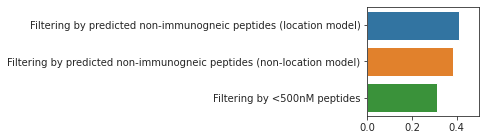

In [28]:
plt.figure(figsize=(2,2))
sns.barplot(x=e_list, y=label_list)
plt.xlim(0,0.5)
plt.show()